In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
from collections import Counter
import tensorflow as tf
import keras
from tensorflow.keras import layers

In [2]:
f = h5py.File('mouse1sample1.hdf5','r')

In [4]:
# Generate 
genes = set()
annotated_cells = []
annotations = []

for cell_id in f['cells']:
    cell = f['cells'][cell_id]
    ann = dict(cell.attrs)['annotation']
    if ann != 'unannotated':
        annotated_cells.append(cell_id)
        annotations.append(ann)
    for z in cell.attrs['zslices']:
        spot_genes = cell['spot_genes'][z]
        genes.update(set(spot_genes))
annotations_count = Counter(annotations)

Number of Annotated Samples: 18453
Num of Cell Types: 93
Max Number of Samples per Cell Type: 2136
Min Number of Samples per Cell Type: 1
Average Number of Samples per Cell Type: 198.41935483870967


<BarContainer object of 93 artists>

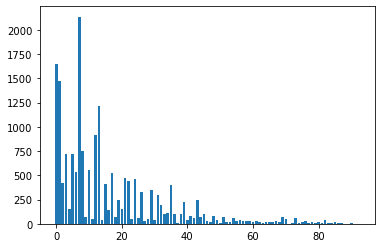

In [5]:
print("Number of Annotated Samples:", len(annotated_cells))
print("Num of Cell Types:", len(annotations_count))
print("Max Number of Samples per Cell Type:", max(annotations_count.values()))
print("Min Number of Samples per Cell Type:", min(annotations_count.values()))
print("Average Number of Samples per Cell Type:", sum(annotations_count.values())/93)

#graph of num of samples across cell-types 
plt.bar(np.arange(0,93), annotations_count.values())

In [6]:
maxlen = 1508
data_coords = []
data_genes = []
gene_indices = {k: v for v, k in enumerate(set(genes))}

i = 0
for cell_id in annotated_cells:
    cell_coords = []
    cell_genes = []
    cell = f['cells'][cell_id]
    keys = list(cell['boundaries'].keys())
    
    midslice = keys[int(len(keys)/2)]
    boundary = np.array(cell['boundaries'][midslice])

    midpoint = [np.mean(boundary[:,0]), np.mean(boundary[:,1])]

#     cell_coords += list(np.array(boundary) - midpoint)
#     cell_genes += [-1] * len(boundary)
    
    for z in cell.attrs['zslices']:   
        spot_coords = cell['spot_coords'][z]
        spot_genes = cell['spot_genes'][z]
        
        spot_coords = np.array(spot_coords)
        spot_coords -= midpoint
        spot_coords = np.absolute(spot_coords)

        cell_coords += list(spot_coords)
        cell_genes += [gene_indices[gene] for gene in list(spot_genes)]
    
    data_coords.append(cell_coords)
    data_genes.append(cell_genes)


data_coords = keras.preprocessing.sequence.pad_sequences(np.array(data_coords), maxlen = maxlen, value=-1)
data_genes = np.expand_dims(keras.preprocessing.sequence.pad_sequences(np.array(data_genes), maxlen=maxlen, value=-1), axis=-1)


data = np.concatenate([data_coords, data_genes], axis=-1)
print(data.shape)
np.save('data_noboundary.npy', data)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


(18453, 1508, 3)


In [33]:
maxlen = 1508
with open('data_noboundary.npy', 'rb') as file:
    data = np.load(file)
print(data.shape)

(18453, 1682, 3)


In [7]:
# creating one-hot coded vectors for cell-type (labels for multi)
annotation_indices = {k: v for v, k in enumerate(list(annotations_count.keys()))}
labels = np.zeros((len(annotated_cells), len(annotation_indices)))
for index in range(len(annotated_cells)):
    cell = f['cells'][annotated_cells[index]]
    ann = dict(cell.attrs)['annotation']
    arr_index = annotation_indices[ann]
    labels[index][arr_index] = 1

In [8]:
from sklearn.model_selection import train_test_split

train, test, train_y, test_y = train_test_split(data, labels, test_size=0.3)
test, val, test_y, val_y = train_test_split(test, test_y, test_size=0.5)

val = keras.preprocessing.sequence.pad_sequences(val, maxlen=maxlen)
test = keras.preprocessing.sequence.pad_sequences(test, maxlen=maxlen)

print(train.shape, train_y.shape)
print(val.shape, val_y.shape)
print(test.shape, test_y.shape)

(12917, 1508, 3) (12917, 93)
(2768, 1508, 3) (2768, 93)
(2768, 1508, 3) (2768, 93)


In [9]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [10]:
class GeneAndPositionEmbedding(layers.Layer):
    def __init__(self, xcoord_size, ycoord_size, vocab_size, embed_dim):
        super(GeneAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.x_emb = layers.Embedding(input_dim=xcoord_size, output_dim=embed_dim)
        self.y_emb = layers.Embedding(input_dim=ycoord_size, output_dim=embed_dim)

    def call(self, x):
        xcoord = self.x_emb(x[:,:,0])
        ycoord = self.y_emb(x[:,:,1])
        genes = self.token_emb(x[:,:,-1])
        return xcoord + ycoord + genes

In [26]:
# Temporary code to get coord_size for use in the embedding layer (found to be 10880)

minx = 0
maxx = 0
miny = 0
maxy = 0

for point in data:
    for coord in point:
        if coord[0] > maxx:
            maxx = coord[0]
        if coord[0] < minx:
            minx = coord[0]
            
        if coord[1] > maxy:
            maxy = coord[1]
        if coord[1] < miny:
            miny = coord[1]
        
    
print(maxx - minx)
print(maxy - miny)

10880
7374


In [11]:
embed_dim = 32  # Embedding size for each token
num_heads = 3  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
vocab_size = len(genes)
xcoord_size = 10880
ycoord_size = 7374
num_transformer_blocks = 2

inputs = layers.Input(shape=(maxlen,3))
embedding_layer = GeneAndPositionEmbedding(xcoord_size, ycoord_size, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
for i in range(num_transformer_blocks):
    x = transformer_block(x)

x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(93, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

2021-12-10 06:59:54.534112: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-10 06:59:54.548782: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-10 06:59:54.549522: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-10 06:59:54.550943: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [12]:
#TODO: Prevent overfitting, experiment with learning rate
lr= tf.keras.optimizers.schedules.ExponentialDecay(
    0.001,
    decay_steps=100000, #100000
    decay_rate=0.95,
    staircase=True)

model.compile(optimizer=tf.optimizers.Adam(learning_rate=lr), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.AUC(curve='PR')])
history = model.fit(
    train, train_y, batch_size=32, epochs=20, validation_data=(val, val_y)
)

2021-12-10 06:59:55.552442: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
404/404 [==============================] - 197s 482ms/step - loss: 2.5494 - accuracy: 0.4020 - auc: 0.4128 - val_loss: 1.3642 - val_accuracy: 0.6745 - val_auc: 0.7305
Epoch 2/20
404/404 [==============================] - 194s 481ms/step - loss: 1.2677 - accuracy: 0.6738 - auc: 0.7327 - val_loss: 0.9560 - val_accuracy: 0.7435 - val_auc: 0.8233
Epoch 3/20
404/404 [==============================] - 193s 478ms/step - loss: 1.0370 - accuracy: 0.7143 - auc: 0.7858 - val_loss: 0.8105 - val_accuracy: 0.7702 - val_auc: 0.8526
Epoch 4/20
404/404 [==============================] - 194s 480ms/step - loss: 0.9174 - accuracy: 0.7415 - auc: 0.8171 - val_loss: 0.7200 - val_accuracy: 0.7905 - val_auc: 0.8744
Epoch 5/20
404/404 [==============================] - 193s 479ms/step - loss: 0.8331 - accuracy: 0.7624 - auc: 0.8380 - val_loss: 0.7177 - val_accuracy: 0.7876 - val_auc: 0.8719
Epoch 6/20
404/404 [==============================] - 194s 480ms/step - loss: 0.7895 - accuracy: 0.7683 - auc:

In [52]:
model.save('./transformer_model')

INFO:tensorflow:Assets written to: ./transformer_model/assets


INFO:tensorflow:Assets written to: ./transformer_model/assets


In [25]:
model = keras.models.load_model('./transformer_model')

In [13]:
model.evaluate(test, test_y)

87/87 [==============================] - 15s 174ms/step - loss: 0.6383 - accuracy: 0.8154 - auc: 0.8952


[0.6383054852485657, 0.8153901696205139, 0.8951987624168396]

In [14]:
from sklearn.metrics import balanced_accuracy_score

y_pred = model.predict(test)
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(test_y, axis=1)
print(y_pred.shape)
print(y_test.shape)

balanced_accuracy_score(y_test, y_pred)

(2768,)
(2768,)


0.49949939697431317

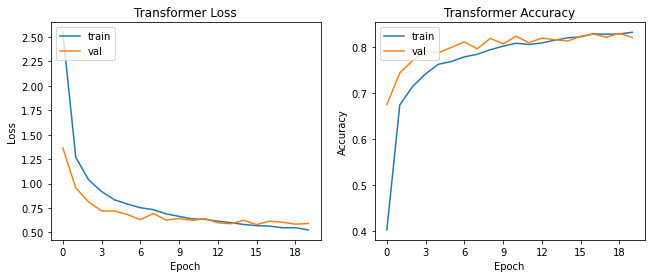

In [28]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# fig, axs = plt.subplots(2,2)

# axs[0, 1].plot(history.history['accuracy'])
# axs[0,1].plot(history.history['val_accuracy'])
# axs[0,0].title('Transformer Accuracy')

# axs[0,0].plot(history.history['loss'])
# axs[0,0].plot(history.history['val_loss'])
# axs[0,0].title('Transformer Loss')

f, (ax1, ax2) = plt.subplots(1, 2)
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])

ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])

ax1.set_title('Transformer Loss')
ax2.set_title('Transformer Accuracy')



# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')
ax2.legend(['train', 'val'], loc='upper left')
plt.subplots_adjust(right=1.5)
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()